In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype'] = 42  # Use TrueType fonts
rcParams['axes.linewidth'] = 0.5
rcParams['xtick.major.width'] = 0.5
rcParams['ytick.major.width'] = 0.5

    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   False        True  5.191592  207.881379   
1  condition  arg-phe  phe-arg   False        True  0.121495  268.865852   
2  condition  arg-phe  phe-trp   False        True  3.751807  218.606341   
3  condition    naive  phe-arg   False        True -5.482205  189.776540   
4  condition    naive  phe-trp   False        True -1.716132  178.000000   
5  condition  phe-arg  phe-trp   False        True  3.965272  208.161220   

  alternative         p-unc       BF10    hedges  
0   two-sided  4.950987e-07  2.773e+04  0.684660  
1   two-sided  9.033896e-01      0.131  0.014470  
2   two-sided  2.249317e-04     96.404  0.482956  
3   two-sided  1.326632e-07  1.099e+05 -0.725882  
4   two-sided  8.787763e-02      0.632 -0.254746  
5   two-sided  1.007974e-04    203.208  0.508865  
    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   F

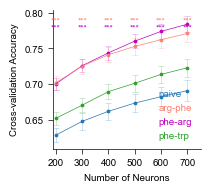

In [ ]:
import os
from os.path import join as pjoin
import pandas as pd
from itertools import product
from catrace.exp_collection import read_df

def read_dfs_from_dir(dist_dir, exp_list, num_repeats, metric, manifold_names):
    # Multiply sample numbers with exp_list
    keys = list(product(exp_list, range(num_repeats)))
    keys = [(exp[0], exp[1], k) for exp, k in keys]

    dfs = []
    for exp_name, condition, k in keys:
        in_dir = os.path.join(dist_dir, f'repeat{k:02d}')
        df = read_df(in_dir, exp_name, verbose=False)
        dfs.append(df)

    all_df = pd.concat(
        dfs, keys=keys, names=['fish_id', 'condition', 'sample']
    )
    return all_df


from catrace.utils import get_unordered_odor_pairs

def summarize_dfs(svm_dir, dsconfig, num_repeats, metric, manifold_names, odor_group_name):  # <<< MODIFIED (LDA -> SVM)
    all_df = read_dfs_from_dir(svm_dir, dsconfig.exp_list, num_repeats, metric, manifold_names)  # <<< MODIFIED (LDA -> SVM)
    if odor_group_name == 'aa_ba':
        odor_group1 = dsconfig.odors_aa
        odor_group2 = dsconfig.odors_ba
    else:
        odor_group1 = dsconfig.odors_stimuli
        odor_group2 = dsconfig.odors_stimuli
    odor_pairs = get_unordered_odor_pairs(odor_group1, odor_group2)
    lines = []
    for odor1, odor2 in odor_pairs:
        idx = (all_df['manifold1'] == odor1) & (all_df['manifold2'] == odor2)
        line = all_df[idx]
        if line.empty:
            print(f'No data for odor pair: {odor1}, {odor2}')
            continue
        lines.append(line)
    filtered_df = pd.concat(lines)
    # Set manifold1 and manifold2 as index
    filtered_df = filtered_df.set_index(['manifold1', 'manifold2'], append=True)

    # Compute mean for each fish and condition
    svm_df = filtered_df.groupby(level=('fish_id', 'condition', 'manifold1', 'manifold2'))['mean_svm_cv_score'].mean()  # <<< MODIFIED (LDA -> SVM)

    return svm_df  # <<< MODIFIED (LDA -> SVM)



sample_sizes = [200, 300, 400, 500, 600, 700]

from catrace.dataset import load_dataset_config
dataset_name = 'juvenile'
dsconfig = load_dataset_config(f'../dataset_configs/{dataset_name}_dataset.json')

from analysis_config import juvenile_window_name_to_frames
window_name = 'time_window_5s'
window = juvenile_window_name_to_frames[window_name]


num_repeats = 50
metric = 'svm_cv_acc_manifold_pair'  # <<< MODIFIED (LDA -> SVM)
manifold_names = dsconfig.odors_stimuli
odor_group_name = 'all'
#odor_group_name = 'aa_ba'


svm_dfs = []  # <<< MODIFIED (LDA -> SVM)
for sample_size in sample_sizes:
    svm_name = (  # <<< MODIFIED (LDA -> SVM)
        f'svm_cv_acc_manifold_pair_sample_size{sample_size}_seed8989_window{window[0]}to{window[1]}'  # <<< MODIFIED (LDA -> SVM)
        f'_kernel_linear_C_1.0_gamma_scale_k_3'  # <<< MODIFIED (LDA -> SVM)
    )
    svm_dir = pjoin(dsconfig.processed_trace_dir, svm_name)  # <<< MODIFIED (LDA -> SVM)
    svm_df = summarize_dfs(svm_dir, dsconfig, num_repeats, metric, manifold_names, odor_group_name)  # <<< MODIFIED (LDA -> SVM)
    svm_dfs.append(svm_df)  # <<< MODIFIED (LDA -> SVM)


all_svm_df = pd.concat(  # <<< MODIFIED (LDA -> SVM)
        svm_dfs, keys=sample_sizes, names=['sample_size']  # <<< MODIFIED (LDA -> SVM)
    )

# rename last column as metric
all_svm_df.reset_index(level='sample_size')  # <<< MODIFIED (LDA -> SVM)



    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   False        True  5.191592  207.881379   
1  condition  arg-phe  phe-arg   False        True  0.121495  268.865852   
2  condition  arg-phe  phe-trp   False        True  3.751807  218.606341   
3  condition    naive  phe-arg   False        True -5.482205  189.776540   
4  condition    naive  phe-trp   False        True -1.716132  178.000000   
5  condition  phe-arg  phe-trp   False        True  3.965272  208.161220   

  alternative         p-unc       BF10    hedges  
0   two-sided  4.950987e-07  2.773e+04  0.684660  
1   two-sided  9.033896e-01      0.131  0.014470  
2   two-sided  2.249317e-04     96.404  0.482956  
3   two-sided  1.326632e-07  1.099e+05 -0.725882  
4   two-sided  8.787763e-02      0.632 -0.254746  
5   two-sided  1.007974e-04    203.208  0.508865  
    Contrast        A        B  Paired  Parametric         T         dof  \
0  condition  arg-phe    naive   F

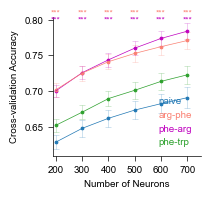

In [7]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

accdf = all_svm_df.reset_index(level='sample_size')  # <<< MODIFIED (LDA -> SVM)
orig_metric_name = 'mean_svm_cv_score'  # <<< MODIFIED (LDA -> SVM)

# Group and compute mean + std
summary = accdf.groupby(['sample_size', 'condition']).agg(
    mean_cv_acc=(orig_metric_name, 'mean'),
    std_cv_acc=(orig_metric_name, 'std'),
    sem_cv_acc=(orig_metric_name, 'sem'),
).reset_index()


from matplotlib.ticker import MultipleLocator

plot_mode = 'paper' #'notebook' # 'paper'

if plot_mode == 'paper':
    figsize = (1.9, 1.8)
    markersize = 2
    linewidth = 0.5
else:
    figsize = (6, 5)
    markersize = 5
    linewidth = 1

color_dict = {'naive': 'tab:blue',
              'arg-phe': 'salmon',
              'phe-arg': 'm',
              'phe-trp': 'tab:green',
}
fig, ax = plt.subplots(figsize=figsize)


# Add error bars manually for std
for condition in summary['condition'].unique():
    subset = summary[summary['condition'] == condition]
    ax.errorbar(
        subset['sample_size'],
        subset['mean_cv_acc'],
        yerr=subset['sem_cv_acc'],
        fmt='none', capsize=2,
        color=color_dict[condition],
        linewidth=0.5,
        capthick=0.5,
        alpha=0.3
    )

# Plot with seaborn
sns.lineplot(
    data=summary,
    x='sample_size',
    y='mean_cv_acc',
    hue='condition',
    marker='o',
    markersize=markersize,
    palette=color_dict,
    hue_order=reversed(dsconfig.conditions),
    ax=ax,
    linewidth=0,
    alpha=1,
    mec=None,
    mew=0.7,
)

sns.lineplot(
    data=summary,
    x='sample_size',
    y='mean_cv_acc',
    hue='condition',
    palette=color_dict,
    hue_order=reversed(dsconfig.conditions),
    ax=ax,
    linewidth=linewidth,
    alpha=1,
    marker=None,
    legend=False,
    err_style="bars",
)

sns.despine(ax=ax)


import matplotlib.lines as mlines

handles, labels = ax.get_legend_handles_labels()
desired_order = ["naive", "arg-phe", "phe-arg", "phe-trp"]

ordered_handles = []
ordered_labels = []
for name in desired_order:
    idx = labels.index(name)
    ordered_handles.append(handles[idx])
    ordered_labels.append(labels[idx])

dummy_handles = [mlines.Line2D([], [], linestyle='none') for _ in ordered_handles]

legend = ax.legend(
    dummy_handles,
    ordered_labels,
    title=None,
    frameon=False,
    fontsize=7,
    loc='lower right'
)

for text_obj, real_handle in zip(legend.get_texts(), ordered_handles):
    try:
        color = real_handle.get_color()
    except AttributeError:
        color = real_handle.get_facecolor()
    text_obj.set_color(color)

ax.tick_params(axis='both', which='both', labelsize=7)
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.set_ylabel("Cross-validation Accuracy", fontsize=7)
ax.set_xlabel("Number of Neurons", fontsize=7)
ax.set_xlim((190, 750))


# Statistics
test_results_list = []
for num_neurons in sample_sizes:
    subdf = all_svm_df.xs(num_neurons, level='sample_size')  # <<< MODIFIED (LDA -> SVM)
    subdf = subdf.to_frame()

    yname = 'mean_svm_cv_score'  # <<< MODIFIED (LDA -> SVM)

    from catrace.stats import apply_test_by_cond
    from catrace.visualize import pvalue_to_marker
    test_results = apply_test_by_cond(
        subdf,
        yname,
        naive_name='naive',
        cond_name='condition',
        test_type='kruskal',
        return_all_pairs=False,
        padjust='bonf',
    )
    test_results_list.append(test_results)

    for idx, condition in enumerate(dsconfig.conditions):
        if condition == 'naive':
            continue
        pvalue = test_results['Dunn_naive']['p_values'][condition]
        marker, xoffset = pvalue_to_marker(pvalue)
        if marker != 'n.s.':
            yoffset = -0.01 * idx
            if num_neurons == 25:
                yoffset -= 0.02
            ax.text(num_neurons + xoffset, 0.82+yoffset, marker, fontsize=6, ha='center', va='center', color=color_dict[condition])


fig_dir = f'../figures/{dataset_name}/{window_name}/svm/'  # <<< MODIFIED (LDA -> SVM)
os.makedirs(fig_dir, exist_ok=True)

fig.savefig(pjoin(fig_dir, f'svm_n_curve_odor_pair_{odor_group_name}.pdf'), bbox_inches='tight')  # <<< MODIFIED (LDA -> SVM)


from catrace.stats import format_test_results_by_cond
for i, num_neurons in enumerate(sample_sizes):
    test_results = test_results_list[i]
    text_output = format_test_results_by_cond(test_results)
    print(f'Sample size {num_neurons}:')
    print(text_output)
